In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# Import data
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])  
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,w_m,N
0,10001,2009-12-31,0.162621,4361.0,10.3000,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,0.000005,91
1,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.000005,91
2,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.000004,91
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.000007,91
4,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.000007,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383514,93426,2023-08-31,-0.037156,12581.0,36.0200,453167.6200,422469.9800,0.004463,-0.020605,1,-0.041619,-0.025068,0.000019,160
1383515,93426,2023-09-29,-0.067740,12581.0,33.5800,422469.9800,376423.5200,0.004472,-0.047390,1,-0.072212,-0.051862,0.000018,160
1383516,93426,2023-10-31,-0.108993,12581.0,29.9200,376423.5200,381429.9000,0.004475,-0.028867,1,-0.113468,-0.033342,0.000017,160
1383517,93426,2023-11-30,0.019051,12510.0,30.4900,381429.9000,426215.7000,0.004455,0.092057,1,0.014596,0.087602,0.000018,160


In [3]:
data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')

## Compute Stock-Specific Betas

/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/3701368349.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Parameters = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'],x[['const','Rm_e']]).fit().params).reset_index()
/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/3701368349.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Systematic_Var = data.groupby('perm

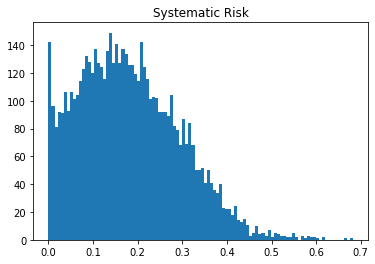

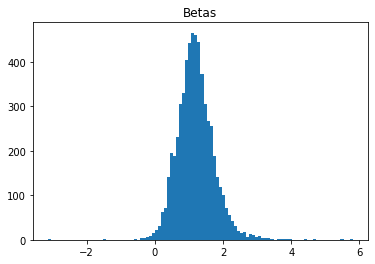

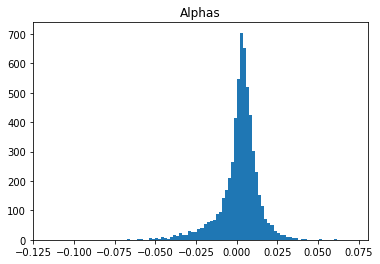

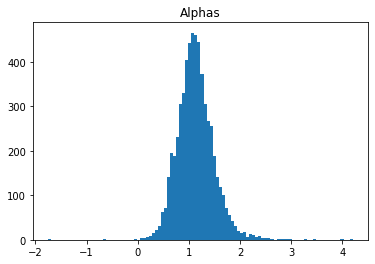

((array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   4.,   3.,   6.,
           8.,  16.,  21.,  31.,  62.,  72., 140., 196., 188., 230., 306.,
         330., 404., 441., 465., 459., 445., 372., 304., 266., 256., 189.,
         142., 119., 101.,  72.,  56.,  43.,  30.,  19.,  15.,  18.,   7.,
          14.,  11.,   6.,   8.,   3.,   3.,   4.,   1.,   0.,   2.,   1.,
           1.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
           1.]),
  array([-1.74836541, -1.68886515, -1.62936489, -1.56986463, -1.51036437,
         -1.45086412, -1.39136386, -1.3318636 , -1.27236334, -1.21286308,
         -1.15336282, -1.09386257, -1.03436231, -0.97486205, -0.91536179,
         -0.85586153, -0.79636128, -0.73686102, -0.67736076, -0.6178605 ,
         -0.

In [4]:
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

#Keep stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# Estimate Betas
import statsmodels.api as sm
Parameters = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'],x[['const','Rm_e']]).fit().params).reset_index()
Parameters = Parameters.rename(columns={'Rm_e':'beta','const':'alpha'})
Systematic_Var = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'],x[['const','Rm_e']]).fit().rsquared)

# Shrinkage Estimator
Parameters['beta_shrinkage'] = (2/3)*Parameters['beta'] + (1/3)
plt.hist(Systematic_Var,bins=100),plt.title('Systematic Risk') , plt.show()
plt.hist(Parameters.beta,bins=100),plt.title('Betas') , plt.show()
plt.hist(Parameters.alpha,bins=100),plt.title('Alphas') , plt.show()
plt.hist(Parameters.beta_shrinkage,bins=100),plt.title('Alphas') , plt.show()

## Sort Betas into Portfolios

In [5]:
Portfolios = pd.merge(data[['date','permno','mcap_l','Rn']],Parameters,on=['permno'], how='left')

Portfolios['Decile'] = Portfolios.groupby('date')['beta'].transform(lambda x: pd.qcut(x,10,labels=False))

# Market Weights
Portfolios['wm'] = Portfolios['mcap_l']/Portfolios.groupby(['date','Decile'])['mcap_l'].transform('sum')
Portfolios['Beta_Return_vw'] = Portfolios['Rn']*Portfolios['wm']
Portfolios['Beta_Return_ew'] = Portfolios['Rn']/Portfolios.groupby(['date','Decile'])['permno'].transform('count')

#Value-Weighted and Equal-Weighted Return
Portfolio_Return = Portfolios.groupby(['date','Decile'])[['Beta_Return_vw','Beta_Return_ew']].sum().reset_index()

Rm = data[['date','Rm']].drop_duplicates()
Rf = data[['date','rf']].drop_duplicates()
Portfolio_Return = pd.merge(Portfolio_Return, Rm,on=['date'], how='left')
Portfolio_Return = pd.merge(Portfolio_Return, Rf,on=['date'], how='left').dropna()
Portfolio_Return['Beta_Excess_Return_ew'] = Portfolio_Return['Beta_Return_ew']-Portfolio_Return['rf']
Portfolio_Return['Beta_Excess_Return_vw'] = Portfolio_Return['Beta_Return_vw']-Portfolio_Return['rf']
Portfolio_Return['Rm_e'] = Portfolio_Return['Rm']-Portfolio_Return['rf']


Portfolio_Return['const'] = 1
Portfolio_Beta_ew = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_ew'],x[['const','Rm_e']]).fit().params[1])
Portfolio_Beta_vw = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_vw'],x[['const','Rm_e']]).fit().params[1])

#Average Excess Return of Each Portfolio
Portfolio_Ret_ew = Portfolio_Return.groupby('Decile')['Beta_Excess_Return_ew'].mean()
Portfolio_Ret_vw = Portfolio_Return.groupby('Decile')['Beta_Excess_Return_vw'].mean()

tmp = pd.concat([Portfolio_Beta_ew,Portfolio_Beta_vw,Portfolio_Ret_ew,Portfolio_Ret_vw], axis=1)
tmp.columns = ['beta_ew','beta_vw','ret_ew','ret_vw']
tmp[['ret_ew','ret_vw']] = tmp[['ret_ew','ret_vw']]*12

/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/3064889676.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Portfolio_Beta_ew = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_ew'],x[['const','Rm_e']]).fit().params[1])
/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/3064889676.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Portfolio_Beta_ew = Portfolio_Return.groupby('Decile').apply(lambda x: sm.OLS(x['Beta_Excess_Return_ew'],x[['const','Rm_e']]).fit().params[1])
/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/3064889676.py:2

## Plot Security Market Line

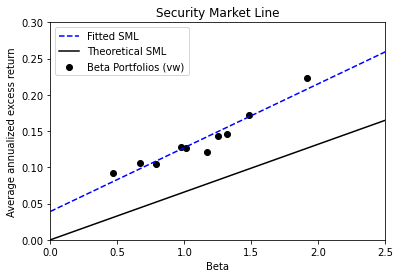

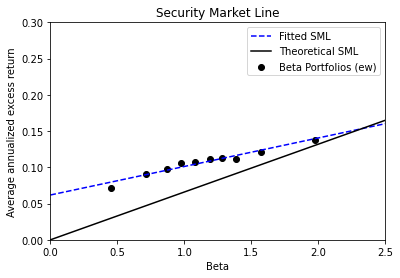

In [6]:
for wt in ['vw','ew']:
    tmp['const'] = 1
    fit = sm.OLS(tmp['ret_'+wt], tmp[['const','beta_'+wt]]).fit()
    fl=fit.params.values[0]+fit.params.values[1]*np.arange(0,4)

    sl= (Rm['Rm'].mean()-Rf['rf'].mean())*np.arange(0,4)*12

    plt.plot(np.arange(0,4),fl,color='blue',linestyle='--')
    plt.plot(np.arange(0,4),sl,color='black')
    plt.scatter(tmp['beta_'+wt],tmp['ret_'+wt],color='black')
    plt.xlabel('Beta')
    plt.ylabel('Average annualized excess return')
    plt.xlim(0, 2.5)
    plt.ylim(0, 0.3)
    plt.title('Security Market Line')
    plt.legend(['Fitted SML','Theoretical SML','Beta Portfolios ('+wt+ ')'], loc=0)
    plt.savefig('SML_Test_' +wt + '.pdf')
    plt.show()

In [7]:
# The CAPM seems violated

# Betting against Beta strategy (BaB)

In [8]:
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()


data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

#Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# Winsorized
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))


## Sort Stocks by Beta Decile

In [9]:

data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Market Weights within quintiles
data['vw_Q'] = data['mcap']/data.groupby(['date','beta_Q'])['mcap'].transform('sum')

# VW Portfolios
data['beta_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

#Equal-Weighted portfolios
ret_ew = data.groupby(['date','beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()



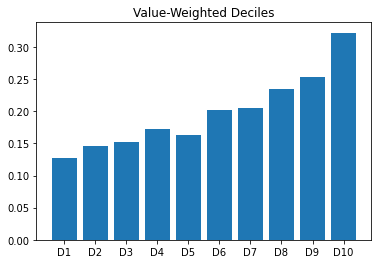

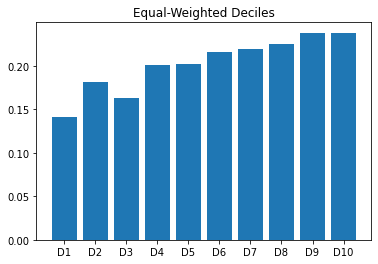

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles'),
 None)

In [10]:

plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_ret_mean*12),plt.title('Value-Weighted Deciles'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_ret_mean*12),plt.title('Equal-Weighted Deciles'), plt.show()

# BAB Factor

In [12]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()

# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']

In [13]:
# cum returns
BAB['Cumulative_BAB1'] = (1 + BAB['BAB1']).cumprod()
BAB['Cumulative_BAB2'] = (1 + BAB['BAB2']).cumprod()

# tot return
total_return_BAB1 = BAB['Cumulative_BAB1'].iloc[-1] - 1
total_return_BAB2 = BAB['Cumulative_BAB2'].iloc[-1] - 1

print(f"Rendement total BAB1: {total_return_BAB1:.2%}")
print(f"Rendement total BAB2: {total_return_BAB2:.2%}")

Rendement total BAB1: -85.86%
Rendement total BAB2: 605.23%


## CAPM Alpha and Market Exposure

In [14]:

tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.06611170332128734 2.6487788269559625
Sharpe Ratio of BAB factor:  0.7538958155565543
Idiosyncatic volatility:  0.11175929884921036
Beta BAB:  0.5013162951102541
Market Risk Premium:  0.07872392238908113
Market Volatility:  0.16833715761798662


/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/2376889423.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Alpha_bab = OLS_Reg.params[0]*12
/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/2376889423.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_bab = OLS_Reg.params[1]
/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24211/2376889423.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

In [15]:
BAB_factor = tmp[['date']].copy()
BAB_factor['BAB_ret'] = tmp['BAB2'] 
BAB_factor.to_csv('BAB_factor_VW.csv', index=False)